# MNIST classification

This tutorial builds a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>, following the tensorflow tutorial to have a term of comparison. The performance of the quantum neural network and the graph version on this classical data problem is compared with a classical neural network. After tons of trial I was not able to train a Graph Neural Network on the Mnist reduced dataset 4x4 for binary classification of digits 3 and 6. Further study of the architecture is needed to figure out what is going wrong and why.  I observed difference in performance betweeen the Quantum Neural Network with input data given as single rotation on each qubit and an input data that takes into account some fixed rotation on qubit pairs following the adjacency matrix. The two Quantum Neural Network have further learned different parameters as expected. The accuracy seems slightly higher when taking into account the adjacency matrix for the input data, however the training time also increase considerably. However, it should be notice that in this case study the network number of gates is comparable to the input data number of gates, hence for much deeper network we expect the slow down to be negligible.
The classical Neural Network outperforms the quantum ones, however it was trained for more epochs, regardless the accuracy tops around 92% and does not seem to be able to grow further.

### To do
At the present moment, there is no yet a standardized procedure to find the best ***learning rate***, we want to implement a Tuner (maybe the one from tensorflow, even better if I can code my own) to find the optimal learning rate, followed with a cyclic learning rate routine, as implemented by <a href="https://arxiv.org/abs/1506.01186" class="external">Leslie N. Smith</a>, in 2015. The procedure is ordinarely used in the Deep Learning community, and I am interested in proving that also in this data provides better results compared to constant, exponentially decreasing and linear decreasing learning rate.

For what it regards the ***batch size*** we found the result from <a href="https://openreview.net/pdf?id=B1Yy1BxCZ" class="external">Samuel L. Smith, Pieter-Jan Kindermans, Chris Ying & Quoc V. Le </a>, they have shown that increasing the batch size provides similar results to decreasing the learning rate but has fewer parameters updates. If it suitable we will try to see if that holds also in training Quantum Neural Networks and (eventually) if it is more or less robust to small noise in data

Turning to ***metrics & loss functions***, I have yet to build a better understanding of the different possibilities and how they influence the training, both in quantum and classical neural networks. 

### Utility of the current work:

I have developed a better understanding of the syntax and standard procedures in Machine Learning, I was able to work effectively with TensorflowQuantum and I know how to setup different conda environment to avoid conflicts between packages. 
I was able to extract from data that has not an inherent graph structure an adjacency matrix and use it for training the Quantum Neural Network. Further research on the classical graph neural network however is needed. I am starting to work on a different dataset, namely the Ising Model 5x5 as last part of playing around. Afterwords, I will deal with Ising Chains and Heisenberg Model. For now we are sticking to classification tasks, therefore the protein datasets might be dealt with next.

## Setup

Now import TensorFlow and the module dependencies:

In [84]:
import cProfile
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [3]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

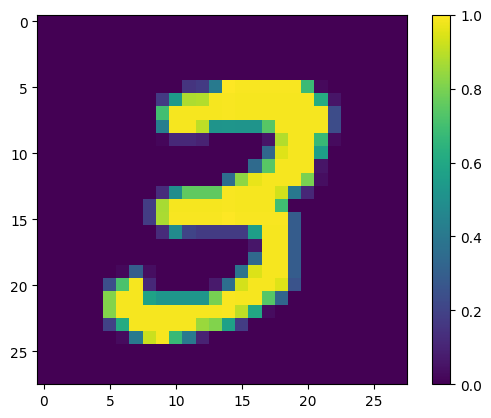

In [82]:
#print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar();

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [6]:
rescale_l=4

x_train_small = tf.image.resize(x_train, (rescale_l,rescale_l)).numpy()
x_test_small = tf.image.resize(x_test, (rescale_l,rescale_l)).numpy()

Again, display the first training example—after resize: 

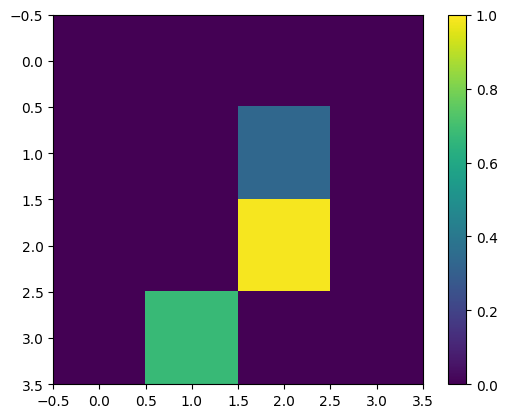

In [83]:
#print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar();

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [8]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
        orig_x[tuple(x.flatten())] = x
        mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
        x = orig_x[flatten_x]
        labels = mapping[flatten_x]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(next(iter(labels)))
        else:
            # Throw out images that match more than one label.
            pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [9]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

In [10]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [11]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [12]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
            
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

In [73]:
import matplotlib.font_manager
help(matplotlib.font_manager)

Help on module matplotlib.font_manager in matplotlib:

NAME
    matplotlib.font_manager - A module for finding, managing, and using fonts across platforms.

DESCRIPTION
    This module provides a single `FontManager` instance, ``fontManager``, that can
    be shared across backends and platforms.  The `findfont`
    function returns the best TrueType (TTF) font file in the local or
    system font path that matches the specified `FontProperties`
    instance.  The `FontManager` also handles Adobe Font Metrics
    (AFM) font files for use by the PostScript backend.
    
    The design is based on the `W3C Cascading Style Sheet, Level 1 (CSS1)
    font specification <http://www.w3.org/TR/1998/REC-CSS2-19980512/>`_.
    Future versions may implement the Level 2 or 2.1 specifications.

CLASSES
    builtins.object
        FontManager
        FontProperties
    
    class FontManager(builtins.object)
     |  FontManager(size=None, weight='normal')
     |  
     |  On import, the `FontManager

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


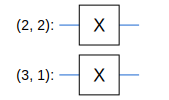

In [79]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [14]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [15]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

The following block contains a method to extract an adjacency matrix from the pixel values in the reshape image

In [16]:
import sklearn
from sklearn import feature_extraction
from scipy.sparse import coo_matrix, vstack

#help(sklearn)
end=len(x_train_bin)

adj_train=[sklearn.feature_extraction.image.img_to_graph(x) for x in x_train_bin[:end]]
adj_test =[sklearn.feature_extraction.image.img_to_graph(x) for x in x_test_bin[:len(x_test_bin)]]
adj_arrays=vstack(adj_train).toarray()
adj_new_test= vstack(adj_test).toarray().reshape(len(x_test_bin), rescale_l**2, rescale_l**2)
print(len(adj_train))
print(type(adj_train[0]))
#print(adj_arrays.reshape(end, rescale_l**2, rescale_l**2))
adj_new= adj_arrays.reshape(end, rescale_l**2, rescale_l**2)
print(adj_new.shape,type(adj_new))
print(len(adj_new[2]), adj_new[2].shape)
print(adj_new_test.shape)


10338
<class 'scipy.sparse._coo.coo_matrix'>
(10338, 16, 16) <class 'numpy.ndarray'>
16 (16, 16)
(1968, 16, 16)


###### In the following block we encoded the input by forcing the graph structure in the circuits.

In [17]:
def convert_to_graph(image,adj_new,index):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(rescale_l, rescale_l)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
            
    for qubit in range(rescale_l**2):
        circuit.append(cirq.H(qubits[qubit]))     
        
    for row in range(len(adj_new[index])):
        for col in range(row):
            if adj_new[index][row][col]>0:
                rot= np.pi/8
                rot=float(rot)
                circuit.append(cirq.ZZ(qubits[row], qubits[col])**rot)
    values = np.ndarray.flatten(image)
    
    for qubit in range(rescale_l**2):
        # Hadamard gate on wire qubit
        circuit.append(cirq.H(qubits[qubit]))

    for row in range(len(adj_new[index])):
        for col in range(row):
            if adj_new[index][row][col] > 0:
                rot= np.pi/8
                rot=float(rot)

                # IsingZZ gate on wires row and col
                circuit.append(cirq.ZZ(qubits[row], qubits[col])**rot)
   
    for qubit in range(rescale_l**2):
        # Hadamard gate on wire qubit
        circuit.append(cirq.H(qubits[qubit]))
    
    return circuit





In [18]:
index=0
x_test_circ_g=[]  
for x in x_test_bin:
    #print(index)
    x_test_circ_g.append(convert_to_graph(x,adj_new_test, index))
    index+=1

In [19]:
x_test_tfcirc_g = tfq.convert_to_tensor(x_test_circ_g)


In [20]:
index=0
x_train_circ_g=[]  
for x in x_train_bin:
    #print(index)
    x_train_circ_g.append(convert_to_graph(x,adj_new, index))
    index+=1


In [21]:
print(len(x_test_circ_g), len(x_test_circ))

1968 1968


In [22]:
print(len(x_train_circ_g), len(x_train_circ))

10338 10338


In [25]:
x_train_tfcirc_g = tfq.convert_to_tensor(x_train_circ_g)

In [26]:
print(x_train_circ_g[0])



                   ┌─────────┐              ┌────────────────┐   ┌────────────────┐                                    ┌────────────────┐   ┌────────────────┐
(0, 0): ───H───H────H───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

(0, 1): ───H───H────H───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

(0, 2): ───H───H────H───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

(0, 3): ───H───H────H───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

(1, 0): ───H───H────H────────────────────────────────────────────────────────────────────────────────────────────────────────────

### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [27]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

In [28]:
class CircuitLayerBuilder_graph():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            
            circuit.append(cirq.H(qubit))  
            
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)
        for i, qubit in enumerate(self.data_qubits):
            
            circuit.append(cirq.H(qubit))  
            

Build an example circuit layer to see how it looks:

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


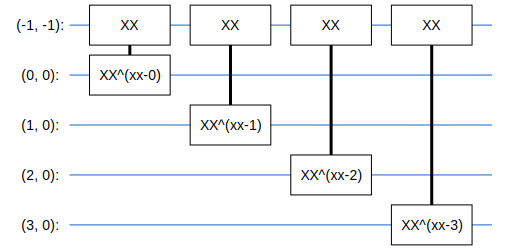

In [29]:
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


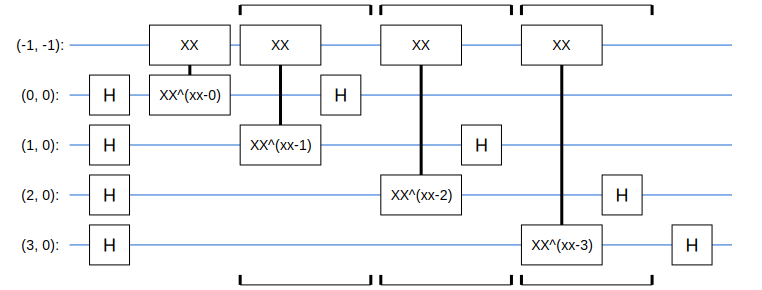

In [30]:
demo_builder = CircuitLayerBuilder_graph(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [31]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)
    
    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    #builder.add_layer(circuit, cirq.ZZ, "zz2")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [32]:
def create_quantum_model_g():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    #The standard procedure was CircuitLayerBuilder, it has not the adj matrix encoded and a different structure
    builder = CircuitLayerBuilder_graph(
        data_qubits = data_qubits,
        readout=readout)
    
    # Then add layers (experiment by adding more).
    #builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")
    builder.add_layer(circuit, cirq.ZZ, "zz2")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [33]:
model_circuit, model_readout = create_quantum_model()
model_circuit_g, model_readout = create_quantum_model_g()

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> prwe use the expectation of a readout qubit in a parameterized circuit. This returns a value between 1 and -1 that can be trivially associated with a binary classification task

In [34]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])
model_g = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit_g, model_readout),
])

Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [35]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [36]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [37]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])
model_g.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [38]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
print(model_g.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


### Train the quantum model

Training the model takes about 15 min on a Ryzen 4800H cpu, OS: Ubuntu 20.04 on WSL2. (Was not able to configure GPU training yet)

In [40]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [41]:
x_train_tfcirc_sub_g = x_train_tfcirc_g[:NUM_EXAMPLES]
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

Training this model to convergence should achieve >85% accuracy on the test set, this refers to not using the graph encoded as input. 

##### Memo: look into data_reuploading afterwards

In [47]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)


Epoch 1/3
324/324 [==============================] - 216s 667ms/step - loss: 0.4119 - hinge_accuracy: 0.8538 - val_loss: 0.3632 - val_hinge_accuracy: 0.8836
Epoch 2/3
324/324 [==============================] - 217s 671ms/step - loss: 0.3801 - hinge_accuracy: 0.8608 - val_loss: 0.3550 - val_hinge_accuracy: 0.8599
Epoch 3/3
62/62 [==============================] - 6s 90ms/step - loss: 0.3491 - hinge_accuracy: 0.8594


Training the following model takes around 20minutes instead. We are encoding the graph structure this time

In [43]:
qnn_history_g = model_g.fit(
      x_train_tfcirc_sub_g, y_train_hinge_sub,
      batch_size=32,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc_g, y_test_hinge))

qnn_results_g = model.evaluate(x_test_tfcirc_g, y_test)


Epoch 1/3
324/324 [==============================] - 384s 1s/step - loss: 0.8780 - hinge_accuracy: 0.6852 - val_loss: 0.7347 - val_hinge_accuracy: 0.8478
Epoch 2/3
324/324 [==============================] - 381s 1s/step - loss: 0.6907 - hinge_accuracy: 0.8651 - val_loss: 0.6447 - val_hinge_accuracy: 0.8987
Epoch 3/3
62/62 [==============================] - 8s 125ms/step - loss: 1.0000 - hinge_accuracy: 0.6321


In [46]:
qnn_results_g = model_g.evaluate(x_test_tfcirc_g, y_test_hinge)
qnn_history_g = model_g.fit(
      x_train_tfcirc_sub_g, y_train_hinge_sub,
      batch_size=32,
      epochs=1,
      verbose=1,
      validation_data=(x_test_tfcirc_g, y_test_hinge))

324/324 [==============================] - 362s 1s/step - loss: 0.6640 - hinge_accuracy: 0.8644 - val_loss: 0.6565 - val_hinge_accuracy: 0.8952


Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 3. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [48]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                      

In [49]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

62/62 [==============================] - 0s 5ms/step - loss: 0.0039 - accuracy: 0.9980


The above model has nearly 1.2M parameters, and trains on the full image. For a fair comparison, consider a smaller Neural network, a 37-parameter model, on the subsampled images:

In [64]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
81/81 - 0s - loss: 0.6706 - accuracy: 0.5426 - val_loss: 0.6193 - val_accuracy: 0.5706 - 480ms/epoch - 6ms/step
Epoch 2/20
81/81 - 0s - loss: 0.5435 - accuracy: 0.7298 - val_loss: 0.4484 - val_accuracy: 0.8064 - 151ms/epoch - 2ms/step
Epoch 3/20
81/81 - 0s - loss: 0.3609 - accuracy: 0.8401 - val_loss: 0.2985 - val_accuracy: 0.8623 - 151ms/epoch - 2ms/step
Epoch 4/20
81/81 - 0s - loss: 0.2714 - accuracy: 0.8716 - val_loss: 0.2495 - val_accuracy: 0.8653 - 153ms/epoch - 2ms/step
Epoch 5/20
81/81 - 0s - loss: 0.2425 - accuracy: 0.8874 - val_loss: 0.2327 - val_accuracy: 0.8653 - 154ms/epoch - 2ms/step
Epoch 6/20
81/81 - 0s - loss: 0.2311 - accuracy: 0.8987 - val_loss: 0.2243 - val_accuracy: 0.9141 - 151ms/epoch - 2ms/step
Epoch 7/20
81/81 - 0s - loss: 0.2256 - accuracy: 0.9016 - val_loss: 0.2204 - val_accuracy: 0.9141 - 152ms/epoch - 2ms/step
Epoch 8/20
81/81 - 0s - loss: 0.2225 - accuracy: 0.9033 - val_loss: 0.2182 - val_accuracy: 0.9141 - 148ms/epoch - 2ms/step
Epoch 9/20
81/81

## 4. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

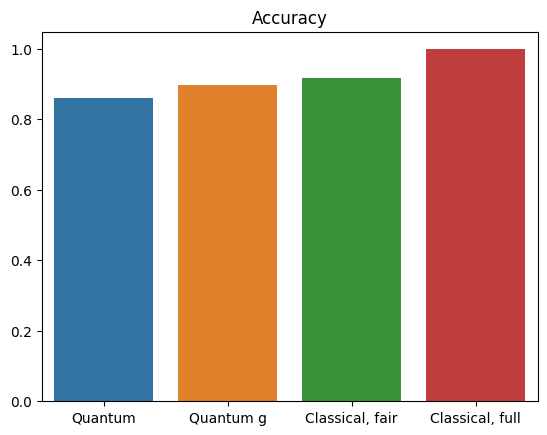

In [66]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]
qnn_accuracy_g  = qnn_results_g[1]

sns.barplot(x=["Quantum", "Quantum g", "Classical, fair", "Classical, full"],
            y=[qnn_accuracy,qnn_accuracy_g , fair_nn_accuracy, cnn_accuracy])
plt.title("Accuracy");